In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_curve

In [ ]:
plt.rc('figure',figsize=(18,11))
sns.set_context('paper',font_scale=2)

# Basic information about the data

In [ ]:
df = pd.read_csv('/kaggle/input/water-potability/water_potability.csv')
df.head()

In [ ]:
potable_count = np.sum(df['Potability'] == 1)
unpotable_count = np.sum(df['Potability'] == 0)
plt.bar(['Potable', 'Unpotable'], [potable_count, unpotable_count]);

# EDA

In [ ]:
axes = pd.plotting.scatter_matrix(df)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

In [ ]:
corr = df.corr()
corr_mask = np.triu(np.ones(shape=corr.shape), k=0)
sns.heatmap(corr, annot=True, mask=corr_mask);

In [ ]:
# Don't include the dependent variable.
predictors_names = df.columns.values[:-1]
class_0_mask = df['Potability'] == 0
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(25, 25))
bins = 30
for predictor, ax in zip(predictors_names, axes.flatten()):
    ax.hist(df[predictor][class_0_mask], alpha=0.3, label='Not potable', bins=bins, density=True)
    ax.hist(df[predictor][~class_0_mask], alpha=0.3, label='Potable', bins=bins, density=True)
    ax.set_xlabel(predictor)
    ax.legend()
fig.suptitle('Distribution of features in classes', fontsize=30, y=0.91);

Might consider dropping Trihalomethanes, since the differences in distributions seem more like random noise rather than anything informative.

In [ ]:
df_predictors = df.iloc[:, :-1]
df_labels = df.iloc[:, -1]
msno.matrix(df_predictors);

The missing data seems to be related to specific predictors rather than samples. Distribution of missing data in samples is somewhat uniform.
<br><br>
There is little correlation between predictors, so I don't think there is a point in looking for predictors correlated with those with missing values to impute data from them. I will impute the missing values from all predictors using KNN.

### Make sure that all values of the predictors are physically probable and possible.

In [ ]:
df.describe()

All ranges of the values seem possible except for ph. While it's hard for me to make some guess about what the real distribution of ph of water bodies is, it also seems highly improbable that it would be 0 or 14, since 0 wouldn't be water at all, but a strong acid and 14 would be a strong base. I don't think water bodies are made out of  car battery acid and drain cleaner fluid.

I'm gonna base my assumption about the probable range of ph of water on this image found here: https://www.medicalnewstoday.com/articles/327185#ph-of-drinks
# 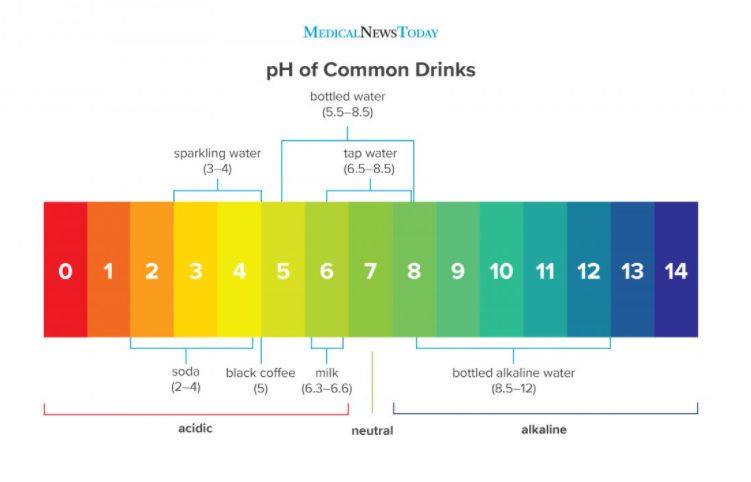
<br>
Water ph can possibly have a wide range, but I think that anything below 1 and above 13 is improbable, so I will delete those observations.

In [ ]:
df.loc[df['ph'] <= 1]

In [ ]:
df.loc[df['ph'] >= 13]

In [ ]:
df = df[(df['ph'] > 1) & (df['ph'] < 13)]
df.describe()

# Preprocessing
1. Split data.
2. Impute data.
3. Center, scale, skewness.

#### Create 2 datasets with:
- all predictors and imputation
- without Trihalomethanes (because of its distribution and missing values) and imputation

### Split the data

In [ ]:
df_predictors = df.iloc[:, :-1]
df_labels = df.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(df_predictors, df_labels, test_size=0.30,
                                                    stratify=df_labels)
X_train_imputed = X_train.copy()
X_train_imputed_no_tri = X_train.drop(columns='Trihalomethanes').copy()
X_test_imputed = X_test.copy()
X_test_imputed_no_tri = X_test.drop(columns='Trihalomethanes').copy()

### Impute the data

In [ ]:
# Convenience function to maintain a df after some sklearn transform().
def np_to_df(arr: np.array, df_original: pd.DataFrame):
    return pd.DataFrame(arr, index=df_original.index, columns=df_original.columns)

In [ ]:
# Since the distinction between classes in dependent variables is quite small I think it will be best for
# the number of neighbours to be large.
n_neighbors = 20
imputer_all = KNNImputer(n_neighbors=n_neighbors)
imputer_no_tri = KNNImputer(n_neighbors=n_neighbors)

X_train_imputed = np_to_df(arr=imputer_all.fit_transform(X_train_imputed), df_original=X_train_imputed)
X_test_imputed = np_to_df(arr=imputer_all.transform(X_test_imputed), df_original=X_test_imputed)
X_train_imputed_no_tri = np_to_df(arr=imputer_no_tri.fit_transform(X_train_imputed_no_tri),
                                  df_original=X_train_imputed_no_tri)
X_test_imputed_no_tri = np_to_df(arr=imputer_no_tri.transform(X_test_imputed_no_tri),
                                 df_original=X_test_imputed_no_tri)

### Skewness, center and scale

In [ ]:
datasets_labels = ['all predictors', 'no Trihalomethanes']
datasets_train = [X_train_imputed, X_train_imputed_no_tri]
datasets_test = [X_test_imputed, X_test_imputed_no_tri]
imputed_predictors = ['ph', 'Sulfate', 'Trihalomethanes']

#### Skewness in original data

In [ ]:
print(f'Skewness in unimputed predictors\n{X_train_imputed.drop(columns=imputed_predictors).skew()}')
for data, label in zip(datasets_train, datasets_labels):
    if label == 'no Trihalomethanes':
        columns = ['ph', 'Sulfate']
    else:
        columns = ['ph', 'Sulfate', 'Trihalomethanes']
    print(f'Skewness in imputed predictors of dataset "{label}"')
    print(data[columns].skew())

In [ ]:
box_cox_all = PowerTransformer(method='box-cox', standardize=True)
box_cox_all.fit(X_train_imputed)
box_cox_tri = PowerTransformer(method='box-cox', standardize=True)
box_cox_tri.fit(X_train_imputed_no_tri)
print(f'Lambdas for dataset with all predictors')
for col, lam in zip(X_train_imputed.columns, box_cox_all.lambdas_):
    print(f'{col}: {lam}')
print(f'\nLambdas for dataset without Trihalomethanes')
for col, lam in zip(X_train_imputed_no_tri.columns, box_cox_tri.lambdas_):
    print(f'{col}: {lam}')

Since none of the lambda values are near zero, all predictors should be transformed.

In [ ]:
X_train_imputed = np_to_df(box_cox_all.transform(X_train_imputed), X_train_imputed)
X_test_imputed = np_to_df(box_cox_all.transform(X_test_imputed), X_test_imputed)
X_train_imputed_no_tri = np_to_df(box_cox_tri.transform(X_train_imputed_no_tri), X_train_imputed_no_tri)
X_test_imputed_no_tri = np_to_df(box_cox_tri.transform(X_test_imputed_no_tri), X_test_imputed_no_tri)

In [ ]:
datasets_labels = ['all predictors', 'no Trihalomethanes']
datasets_train = [X_train_imputed, X_train_imputed_no_tri]
unimputed_predictors = X_train_imputed.drop(columns=imputed_predictors)
print(f'Moments of unimputed predictors:\n'
      f'\tSkewness\n{unimputed_predictors.skew()}\n'
      f'\tMean\n{unimputed_predictors.mean()}\n'
      f'\tStd\n{unimputed_predictors.std()}\n')
for data, label in zip(datasets_train, datasets_labels):
    if label == 'no Trihalomethanes':
        columns = ['ph', 'Sulfate']
    else:
        columns = ['ph', 'Sulfate', 'Trihalomethanes']
    print(f'Moments of imputed predictors of dataset "{label}"\n'
          f'\tSkewness\n{data[columns].skew()}\n'
          f'\tMean\n{data[columns].mean()}\n'
          f'\tStd\n{data[columns].std()}')

# Model building
1. Model selection
2. Model tuning
3. Class probabilities

In [ ]:
datasets_train = [X_train_imputed, X_train_imputed_no_tri]
datasets_test = [X_test_imputed, X_test_imputed_no_tri]

fig, axes = plt.subplots(ncols=2)
for train, test, df_label, ax in zip(datasets_train, datasets_test, datasets_labels, axes):
    forest_score = RandomForestClassifier().fit(train, Y_train).score(test, Y_test)
    svm_score = SVC().fit(train, Y_train).score(test, Y_test)
    logistic_score = LogisticRegression().fit(train, Y_train).score(test, Y_test)
    knn_score = KNeighborsClassifier().fit(train, Y_train).score(test, Y_test)
    qda_score = QuadraticDiscriminantAnalysis().fit(train, Y_train).score(test, Y_test)
    
    pos = np.arange(5)
    accuracies = [forest_score, svm_score, logistic_score, knn_score, qda_score]
    ax.bar(pos, accuracies)
    ax.set_xticks(pos)
    ax.set_xticklabels(['Forest', 'SVM', 'Logistic', 'KNN', 'QDA'])
    ax.set_title(df_label)
    ax.set_ylim(top=0.8)
    rects = ax.patches
    for rect, value in zip(rects, accuracies):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{value:0.2f}', ha='center', va='bottom')

Based on the results I can say that Trihalomethanes does not bring much information to the models, but it also does not hinder them so I might as well just leave it.<br>
The only model not worth pursuing further is Logistic Regression. It does not score well and I wouldn't expect that to change since there is hardly any linear relationship in the data. <br>
For QDA I can only perform cross validation since it does not have any tuning parameters.

### QDA cross validation

In [ ]:
def get_model_cv_acc(model, X: pd.DataFrame, Y: pd.DataFrame, splits=10):
    pipe = Pipeline([('imputer', KNNImputer(n_neighbors=20)), 
                     ('transformer', PowerTransformer(method='box-cox',standardize=True)), ('model', model)])
    scores = cross_val_score(pipe, X, Y, cv=splits)
    return scores.mean()

df_predictors = df.iloc[:, :-1]
df_labels = df.iloc[:, -1]

In [ ]:
print(f'Accuracy of cross-validated QDA model = '
      f'{100 * get_model_cv_acc(QuadraticDiscriminantAnalysis(), df_predictors, df_labels):.2f}%')

## Tuning SVM
1. Kernel choice
2. Penalty

In [ ]:
n_kernels = 3
kernels = ['poly', 'rbf', 'sigmoid']
accuracy_means = np.empty(n_kernels)
for i in range(n_kernels):
    accuracy_means[i] = get_model_cv_acc(SVC(kernel=kernels[i]), df_predictors, df_labels)

pos = np.arange(n_kernels)
fig, ax = plt.subplots()
ax.bar(pos, accuracy_means)
ax.set_ylabel('Accuracy')
ax.set_xticks(pos)
ax.set_xticklabels(kernels)
ax.set_ylim(top=0.8)
for rect, value in zip(ax.patches, accuracy_means):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{value:0.2f}', ha='center', va='bottom')

In [ ]:
c_values = np.linspace(0.5, 1.5, 15)
scores = []
for c in c_values:
    scores.append(get_model_cv_acc(SVC(kernel='rbf', C=c), df_predictors, df_labels))
scores = np.array(scores)
# plt.plot(c_values, scores_stds[0])
plt.plot(c_values, scores)
plt.xlabel('C penalty')
plt.ylabel('Accuracy')
print(f'Best accuracy of {100 * scores.max():.2f}% for C = {c_values[scores.argmax()]}')

## Tuning KNN

In [ ]:
nums_neighbors = np.arange(20, 50)
scores = []
for neighbors in nums_neighbors:
    scores.append(get_model_cv_acc(KNeighborsClassifier(n_neighbors=neighbors), df_predictors, df_labels))
scores = np.array(scores)
plt.plot(nums_neighbors, scores)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
print(f'Best accuracy of {100 * scores.max():.2f}% for '
      f'{nums_neighbors[scores.argmax()]} neighbors')

## Tuning Random Forest
Parameters to tune:
1. Number of features at every split
2. Number of trees
3. Levels in a tree
4. Minimum number of samples to split a node
5. Minimum number of samples required at each leaf node

In [ ]:
n_estimators = np.arange(200, 401, 20)
max_depth = np.arange(10, 111, 10)
min_samples_split = np.arange(3, 10)
min_samples_leaf = np.arange(2, 10)
grid = {'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf}

forest_search = make_pipeline(KNNImputer(n_neighbors=20),
                              PowerTransformer(method='box-cox', standardize=True),
                              RandomizedSearchCV(estimator=RandomForestClassifier(),
                                                 param_distributions=grid,
                                                 n_iter=100,
                                                 cv=5,
                                                 verbose=2))
forest_search.fit(df_predictors, df_labels)

In [ ]:
best_params = forest_search['randomizedsearchcv'].best_params_
best_forest = forest_search['randomizedsearchcv'].best_estimator_
best_score = forest_search['randomizedsearchcv'].best_score_
print(f'The best accuracy of {100 * best_score:.2f}% is achieved by forest with parameters:\n{best_params}')

# Conclusions
The best accuracy is achieved by a SVM with the penalty equal to 1,21. The accuracy of 66.58% is better than the baseline considering proportions of the classes, but not very significantly.